In [1]:
import sys

sys.path.append("..")

import tensorflow as tf

import numpy as np

from utils import tf_config

dataset="01"
memory_limit=1500
interval_eeg=10

tf_config.set_seed(seed=2)#02 [2, 3, 5, 7, 11]
tf_config.setup_tensorflow(device="GPU", memory_limit=memory_limit)

import GPyOpt

import argparse

from utils import preprocess_data, search_algorithms, train, losses_utils, metrics, eeg_utils, data_utils

from models import fmri_ae, eeg_to_fmri, uniconv_fmri

from layers import locally_connected

import matplotlib.pyplot as plt

import gc

import os

from sklearn.model_selection import train_test_split, KFold

from pathlib import Path

import time

import pickle

n_individuals=getattr(data_utils, "n_individuals_"+dataset)

with tf.device('/CPU:0'):
    train_data, test_data = preprocess_data.dataset(dataset, n_individuals=n_individuals,
                                            interval_eeg=interval_eeg, 
                                            ind_volume_fit=False,
                                            standardize_fmri=True,
                                            iqr=False,
                                            verbose=True)
    eeg_train, fmri_train =train_data
    eeg_test, fmri_test = test_data

2022-05-19 14:22:52.165652: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-05-19 14:22:53.337276: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-05-19 14:22:53.337704: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-05-19 14:22:53.384025: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-19 14:22:53.384546: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:0a:00.0 name: GeForce RTX 2080 SUPER computeCapability: 7.5
coreClock: 1.845GHz coreCount: 48 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 462.00GiB/s
2022-05-19 14:22:53.384571: I tensorflow/stream_executor/platform/def

I: Starting to Load Data
I: Finished Loading Data
I: Pairs Created


## Build fMRI AE

In [2]:
theta = (0.002980911194116198, 0.0004396489214334123, (9, 9, 4), (1, 1, 1), 4, (7, 7, 7), 4, True, True, True, True, 3, 1)

In [3]:
#unroll hyperparameters
learning_rate=float(theta[0])
weight_decay = float(theta[1])
kernel_size = theta[2]
stride_size = theta[3]
batch_size=int(theta[4])
latent_dimension=theta[5]
n_channels=int(theta[6])
max_pool=bool(theta[7])
batch_norm=bool(theta[8])
skip_connections=bool(theta[9])
dropout=bool(theta[10])
n_stacks=int(theta[11])
outfilter=int(theta[12])
local=True

In [4]:
with open(str(Path.home())+"/eeg_to_fmri/na_models_eeg/na_specification_2", "rb") as f:
    na_specification_eeg = pickle.load(f)
with open(str(Path.home())+"/eeg_to_fmri/na_models_fmri/na_specification_2", "rb") as f:
    na_specification_fmri = pickle.load(f)

In [5]:
import importlib
importlib.reload(eeg_to_fmri)
low_resolution_factor=2
resolution_decoder = (int(fmri_train.shape[1]/low_resolution_factor),
                     int(fmri_train.shape[2]/low_resolution_factor),
                     int(fmri_train.shape[3]/low_resolution_factor))

with tf.device('/CPU:0'):
    model = eeg_to_fmri.EEG_to_fMRI(latent_dimension, eeg_train.shape[1:], na_specification_eeg, n_channels,
                        weight_decay=weight_decay, skip_connections=True,
                        batch_norm=True, #dropout=False,
                        fourier_features=True,
                        random_fourier=True,
                        topographical_attention=True,
                        conditional_attention_style=True,
                        conditional_attention_style_prior=False,
                        inverse_DFT=True, DFT=True,
                        variational_iDFT=True,
                        variational_coefs=(5,5,5),
                        variational_iDFT_dependent=True,
                        variational_iDFT_dependent_dim=5,
                        variational_dist="VonMises",
                        aleatoric_uncertainty=True,#to compute aleatoric uncertainty
                        low_resolution_decoder=True,
                        resolution_decoder=resolution_decoder,#experimenting
                        local=True, seed=None, 
                        fmri_args = (latent_dimension, fmri_train.shape[1:], 
                        kernel_size, stride_size, n_channels, 
                        max_pool, batch_norm, weight_decay, skip_connections,
                        n_stacks, True, False, outfilter, dropout, None, False, na_specification_fmri))
    
    model.build(eeg_train.shape, fmri_train.shape)
    
    optimizer = tf.keras.optimizers.Adam(learning_rate)
    loss_fn = losses_utils.Laplacian_Loss

    #train_set = tf.data.Dataset.from_tensor_slices((eeg_train, fmri_train)).shuffle(1).batch(batch_size)
    train_set = tf.data.Dataset.from_tensor_slices((eeg_train, fmri_train)).batch(batch_size)
    dev_set= tf.data.Dataset.from_tensor_slices((eeg_test, fmri_test)).batch(1)

In [6]:
loss_history = train.train(train_set, model, optimizer, 
                            loss_fn, epochs=1, 
                            u_architecture=True,
                            val_set=None, verbose=True, verbose_batch=False)[0]

2022-05-19 14:23:48.761444: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-05-19 14:23:48.778835: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3699905000 Hz
2022-05-19 14:23:49.238446: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-05-19 14:23:49.624672: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2022-05-19 14:23:49.647237: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8
2022-05-19 14:23:50.419716: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2022-05-19 14:23:50.451393: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform 

Epoch 1 with loss: 0.9437304427295612


## Playing with plots

#### Single display plot

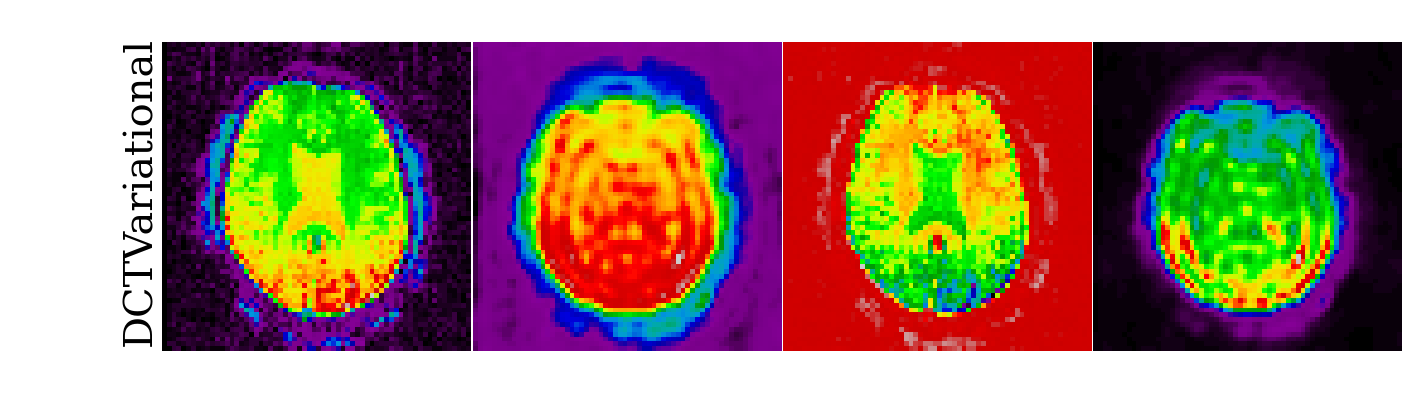

In [93]:

from utils import viz_utils, bnn_utils
from scipy.ndimage import rotate
import copy
import matplotlib as mpl
from matplotlib.gridspec import GridSpec

T = 10
xslice=14

cmap = copy.copy(mpl.cm.get_cmap(plt.cm.nipy_spectral))
cmap.set_over("w")

def normalize_img(img, threshold=0.37):
    img = (img[:,:,:,:]-np.amin(img[:,:,:,:]))/(np.amax(img[:,:,:,:])-np.amin(img[:,:,:,:]))
    img[np.where(img < threshold)]= 1.001
    
    return img
    

    
fig = plt.figure(figsize=(25,7))
gs = GridSpec(2, 9, figure=fig, wspace=0.01, hspace=0.05)#, wspace=-0.4)



for instance_x, instance_y in dev_set.repeat(1):
    
    
    ground_truth = instance_y.numpy()
    y_hat = bnn_utils.predict_MC(model, (instance_x, instance_y), T=T).numpy()
    epistemic = bnn_utils.epistemic_uncertainty(model, (instance_x, instance_y), T=T).numpy()
    aleatoric = model(instance_x, instance_y)[0][1].numpy()
    
    #ground_truth = normalize_img(ground_truth)
    #y_hat = normalize_img(y_hat)
    #epistemic = normalize_img(epistemic)
    #aleatoric = normalize_img(aleatoric)
    
    
    axes = fig.add_subplot(gs[:,0])
    axes.text(0.75,0.13,"DCTVariational", rotation="vertical", size=40)
    
    axes.axis("off")
    #ground truth
    axes = fig.add_subplot(gs[:,1:3])
    axes.imshow(rotate(ground_truth[0,:,:,xslice,0], 90, axes=(0,1)),
              cmap=cmap)
    axes.axis("off")
    #predicted view
    axes = fig.add_subplot(gs[:,3:5])
    axes.imshow(rotate(y_hat[0,:,:,xslice,0], 90, axes=(0,1)),
              cmap=cmap)
    axes.axis("off")
    #epistemic uncertainty
    axes = fig.add_subplot(gs[:,5:7])
    axes.imshow(rotate(epistemic[0,:,:,xslice,0], 90, axes=(0,1)),
              cmap=cmap)
    axes.axis("off")
    #aleatoric uncertainty
    axes = fig.add_subplot(gs[:,7:9])
    axes.imshow(rotate(aleatoric[0,:,:,xslice,0], 90, axes=(0,1)),
              cmap=cmap)
    axes.axis("off")
    
    plt.rcParams["font.family"] = "serif"
    plt.tight_layout()
    plt.show()
    
    break

#### Whole brain display plot

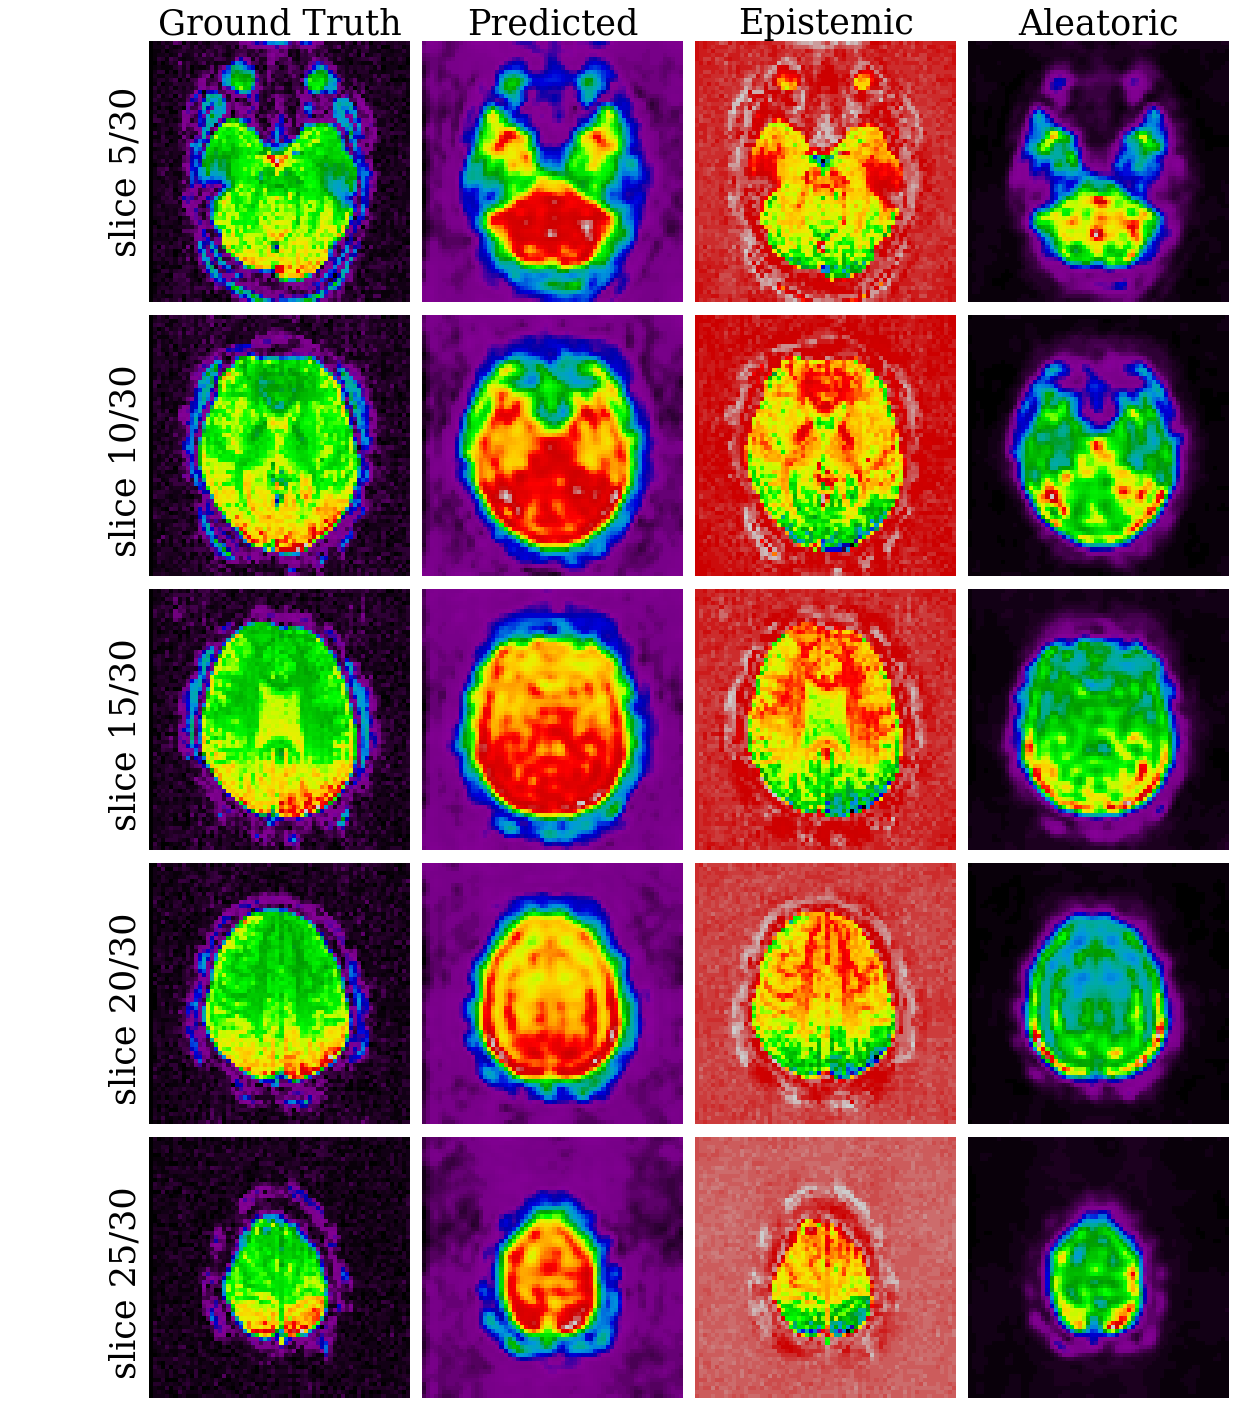

In [94]:
T = 10
factor=5
cmap = copy.copy(mpl.cm.get_cmap(plt.cm.nipy_spectral))
cmap.set_over("w")

    
fig = plt.figure(figsize=(22,30))
gs = GridSpec(ground_truth.shape[3]//factor, 9, figure=fig, wspace=0.01, hspace=0.05)#, wspace=-0.4)

for instance_x, instance_y in dev_set.repeat(1):
    
    
    ground_truth = instance_y.numpy()
    y_hat = bnn_utils.predict_MC(model, (instance_x, instance_y), T=T).numpy()
    epistemic = bnn_utils.epistemic_uncertainty(model, (instance_x, instance_y), T=T).numpy()
    aleatoric = model(instance_x, instance_y)[0][1].numpy()
    
    for xslice in range(factor,ground_truth.shape[3],factor)[::-1]:
        
        axes = fig.add_subplot(gs[xslice//factor-1,0])
        if(xslice==factor):
            x_shift=0.2
        else:
            x_shift=0.1
        axes.text(0.75,x_shift, "slice "+str(xslice)+"/"+str(ground_truth.shape[3]), size=35, rotation="vertical")
        axes.axis("off")
        #ground truth
        axes = fig.add_subplot(gs[xslice//factor-1,1:3])
        axes.imshow(rotate(ground_truth[0,:,:,xslice,0], 90, axes=(0,1)),
                  cmap=cmap)
        if(xslice==factor):
            axes.set_title("Ground Truth", size=35)
        axes.axis("off")
        #predicted view
        axes = fig.add_subplot(gs[xslice//factor-1,3:5])
        axes.imshow(rotate(y_hat[0,:,:,xslice,0], 90, axes=(0,1)),
                  cmap=cmap)
        if(xslice==factor):
            axes.set_title("Predicted", size=35)
        axes.axis("off")
        #epistemic uncertainty
        axes = fig.add_subplot(gs[xslice//factor-1,5:7])
        axes.imshow(rotate(epistemic[0,:,:,xslice,0], 90, axes=(0,1)),
                  cmap=cmap)
        if(xslice==factor):
            axes.set_title("Epistemic", size=35)
        axes.axis("off")
        #aleatoric uncertainty
        axes = fig.add_subplot(gs[xslice//factor-1,7:9])
        axes.imshow(rotate(aleatoric[0,:,:,xslice,0], 90, axes=(0,1)),
                  cmap=cmap)
        if(xslice==factor):
            axes.set_title("Aleatoric", size=35)
        axes.axis("off")

    plt.rcParams["font.family"] = "serif"
    plt.tight_layout()
    plt.show()
    
    break

## Prediction vs ground truth plot

In [ ]:
from utils import viz_utils, bnn_utils

save_path = "/home/ist_davidcalhas/eeg_to_fmri/plots/100_instances/"
plot_format="png"

instance = 1
for instance_x, instance_y in dev_set.repeat(1):
    fig = viz_utils.plot_3D_representation_projected_slices(instance_y.numpy()[0],
                                                           threshold=0.37)
    #plt.savefig(save_path + str(instance) + "_ground_truth."+plot_format, format=plot_format)
    fig.show()
    
    fig = viz_utils.plot_3D_representation_projected_slices(np.mean(bnn_utils.predict_MC(model, (instance_x, instance_y), T=100), axis=0),
                                                            threshold=0.37,)
    #plt.savefig(save_path + str(instance) + "_predicted."+plot_format, format=plot_format)
    fig.show() 
    instance += 1
    break

## Structural Similarity Index

In [8]:
ssim=metrics.ssim(dev_set, model)
print(np.mean(ssim), np.std(ssim))
rmse=metrics.rmse(dev_set, model)
print(np.mean(rmse), np.std(rmse))
sharpness=metrics.sharpness(dev_set, model)
print(np.mean(sharpness), np.std(sharpness))

0.3916814846989377 0.006564658238763433
0.647588 0.02427036


In [9]:
from utils import lrp
explainer = lrp.LRP(model.fmri_encoder)
R=lrp.explain(explainer, dev_set, eeg=False, fmri=True, verbose=True)

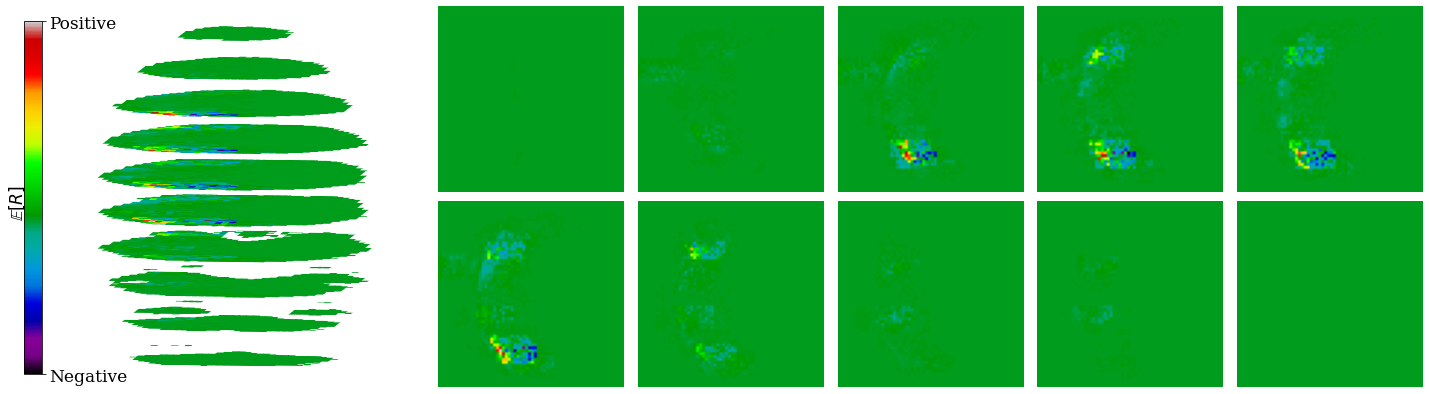

In [10]:
fig = viz_utils.plot_3D_representation_projected_slices(np.mean(R, axis=0),
                                                        res_img=np.mean(fmri_train,axis=0),
                                                        slice_label=False,
                                                        uncertainty=True,
                                                       legend_colorbar=r"$\mathbb{E}[R]$",
                                                       save=True, save_path="/home/ist_davidcalhas/mean_fmri_explainability.pdf",
                                                       max_min_legend=["Negative","Positive"])

### Compute uncertainty

In [11]:
from utils import bnn_utils

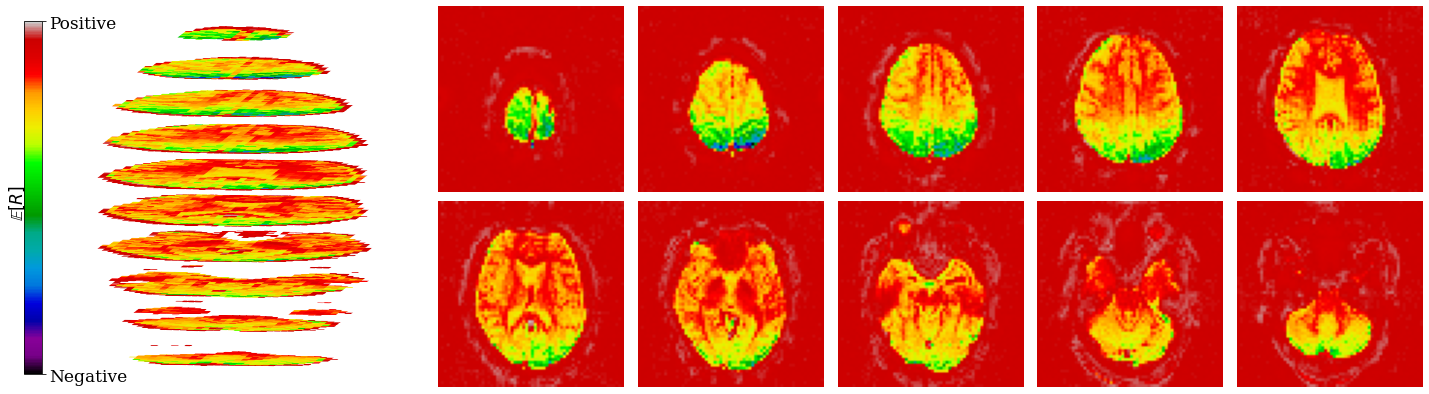

In [12]:
for instance_x, instance_y in dev_set.repeat(1):
    fig = viz_utils.plot_3D_representation_projected_slices(np.mean(bnn_utils.epistemic_uncertainty(model, (instance_x, instance_y), T=100), axis=0),
                                                        res_img=np.mean(fmri_train,axis=0),
                                                        slice_label=False,
                                                        uncertainty=True,
                                                       legend_colorbar=r"$\mathbb{E}[R]$",
                                                       save=False, save_path="/home/ist_davidcalhas/mean_fmri_explainability.pdf",
                                                       max_min_legend=["Negative","Positive"])
    fig.show()
    break

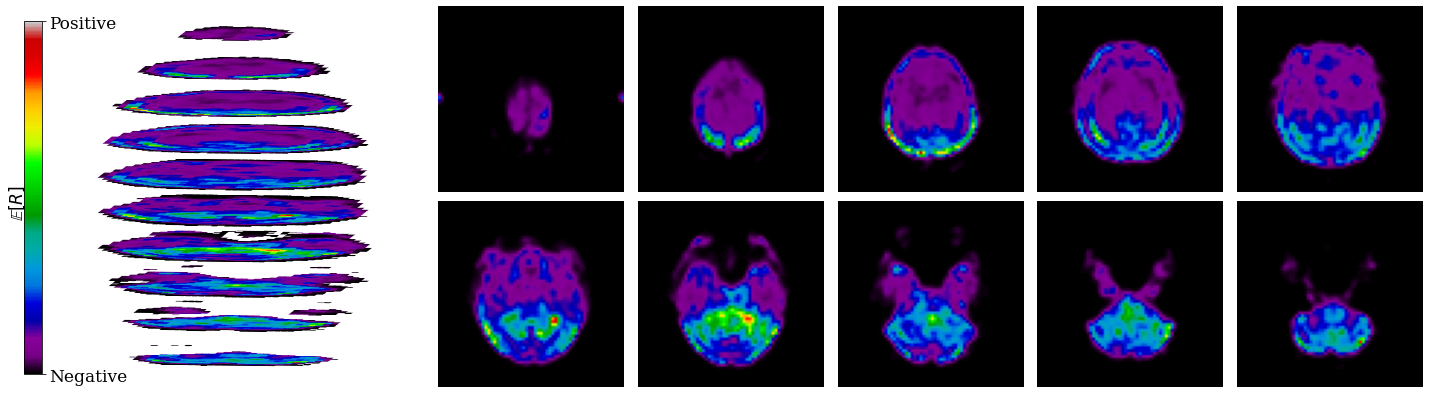

In [13]:
for instance_x, instance_y in dev_set.repeat(1):
    fig = viz_utils.plot_3D_representation_projected_slices(np.mean(bnn_utils.aleatoric_uncertainty(model, (instance_x, instance_y), T=100), axis=0),
                                                        res_img=np.mean(fmri_train,axis=0),
                                                        slice_label=False,
                                                        uncertainty=True,
                                                       legend_colorbar=r"$\mathbb{E}[R]$",
                                                       save=False, save_path="/home/ist_davidcalhas/mean_fmri_explainability.pdf",
                                                       max_min_legend=["Negative","Positive"])
    fig.show()
    break

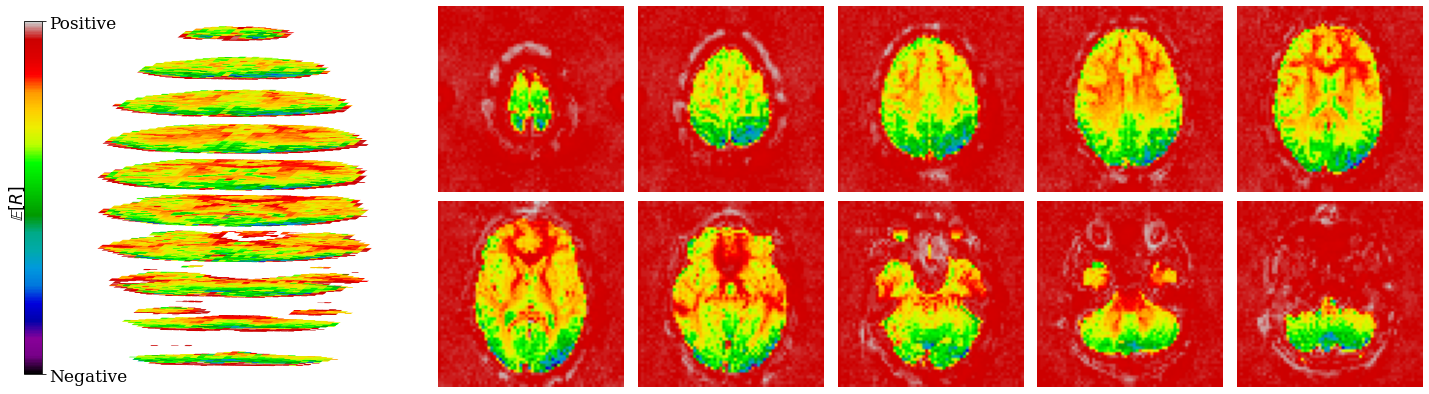

In [14]:
for instance_x, instance_y in train_set.repeat(1):
    fig = viz_utils.plot_3D_representation_projected_slices(np.mean(bnn_utils.epistemic_uncertainty(model, (instance_x, instance_y), T=100), axis=0),
                                                        res_img=np.mean(fmri_train,axis=0),
                                                        slice_label=False,
                                                        uncertainty=True,
                                                       legend_colorbar=r"$\mathbb{E}[R]$",
                                                       save=False, save_path="/home/ist_davidcalhas/mean_fmri_explainability.pdf",
                                                       max_min_legend=["Negative","Positive"])
    fig.show()
    break

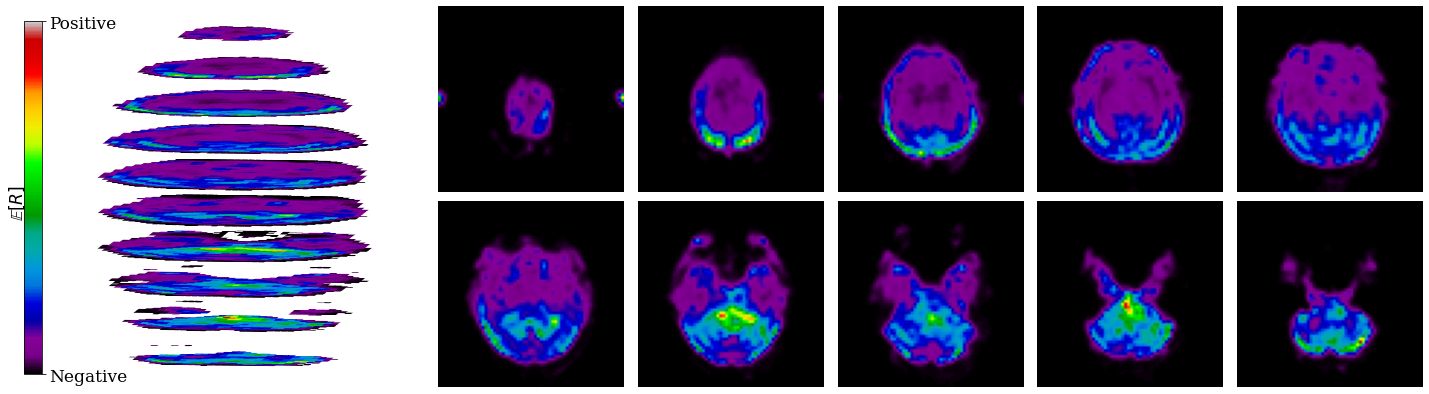

In [15]:
for instance_x, instance_y in train_set.repeat(1):
    fig = viz_utils.plot_3D_representation_projected_slices(np.mean(bnn_utils.aleatoric_uncertainty(model, (instance_x, instance_y), T=100), axis=0),
                                                        res_img=np.mean(fmri_train,axis=0),
                                                        slice_label=False,
                                                        uncertainty=True,
                                                       legend_colorbar=r"$\mathbb{E}[R]$",
                                                       save=False, save_path="/home/ist_davidcalhas/mean_fmri_explainability.pdf",
                                                       max_min_legend=["Negative","Positive"])
    fig.show()
    break